In [2]:
import os; os.chdir('..')
import sys; sys.path.extend(['.'])
os.environ['CC'] = 'gcc-10'
os.environ['CXX'] = 'g++-10'

from PIL import Image

import os
from PIL import Image
import argparse
from tqdm import tqdm
import torch
import torchvision.transforms.functional as TVF
from torchsummary import summary
import numpy as np
from distutils.dir_util import copy_tree
from training.networks import SynthesisLayer
from training.networks import PatchWiseSynthesisLayer
import dnnlib
from scripts.legacy import load_network_pkl

np.random.seed(42)
torch.manual_seed(42)
torch.set_grad_enabled(False)

np.float = float
# np.int = int   #module 'numpy' has no attribute 'int'
# np.object = object    #module 'numpy' has no attribute 'object'
# np.bool = bool    #module 'numpy' has no attribute 'bool'

network_pkl = 'file:///home/chris/projects/ml/alis/lhq1024-snapshot.pkl'
device = 'cuda'

with dnnlib.util.open_url(network_pkl) as f:
    G = load_network_pkl(f)['G_ema'].to(device) # type: ignore
    G.eval()
    G.progressive_growing_update(100000)

for res in G.synthesis.block_resolutions:
    block = getattr(G.synthesis, f'b{res}')
    if hasattr(block, 'conv0'):
        block.conv0.use_noise = False
    block.conv1.use_noise = False

#G.synthesis.cfg.patchwise.enabled = False

/tmp/ipykernel_129338/3962091099.py:16: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.dir_util import copy_tree


/home/chris/.virtualenvs/alis/lib/python3.10/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



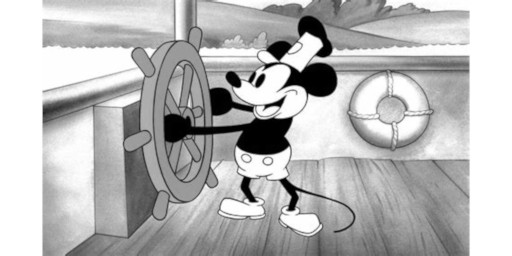


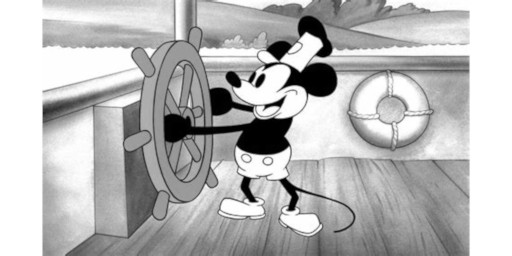


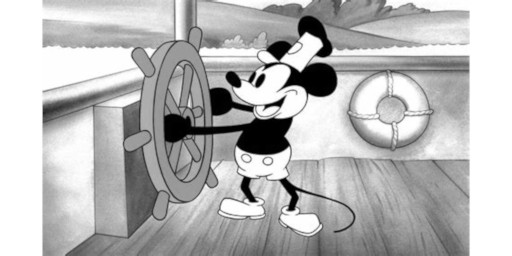


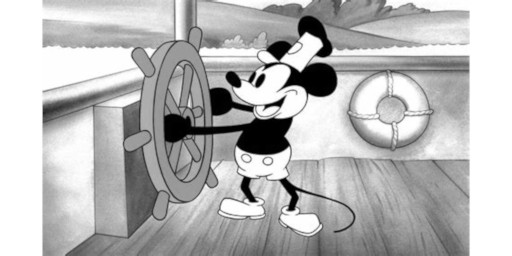

In [10]:
import ipyplot

img1 = Image.open("startup.jpg")
ipyplot.plot_images([img1])


In [7]:
import ipyplot

imgs = []
batch_size = 1
all_ws = torch.tensor([])

modes_idx = torch.zeros(batch_size, device=device).float().long()

G.mapping.num_ws = None
G.synthesis.num_ws = None

def make():
    pred1 = G.synthesis(ws, ws_context=ws_context, left_borders_idx=torch.zeros(batch_size, device=z.device).long(), noise='const')
    pred2 = G.synthesis(ws, ws_context=ws_context, left_borders_idx=torch.zeros(batch_size, device=z.device).long() + 1, noise='const')
    pred3 = G.synthesis(ws, ws_context=ws_context, left_borders_idx=torch.zeros(batch_size, device=z.device).long() + 2, noise='const')
    pred4 = G.synthesis(ws, ws_context=ws_context, left_borders_idx=torch.zeros(batch_size, device=z.device).long() + 3, noise='const')
    pred5 = G.synthesis(ws, ws_context=ws_context, left_borders_idx=torch.zeros(batch_size, device=z.device).long() + 4, noise='const')
    pred6 = G.synthesis(ws, ws_context=ws_context, left_borders_idx=torch.zeros(batch_size, device=z.device).long() + 5, noise='const')
    pred7 = G.synthesis(ws, ws_context=ws_context, left_borders_idx=torch.zeros(batch_size, device=z.device).long() + 6, noise='const')

    img1 = TVF.resize(TVF.to_pil_image(pred1[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 340, interpolation=Image.Resampling.LANCZOS)
    img2 = TVF.resize(TVF.to_pil_image(pred2[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 340, interpolation=Image.Resampling.LANCZOS)
    img3 = TVF.resize(TVF.to_pil_image(pred3[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 340, interpolation=Image.Resampling.LANCZOS)
    img4 = TVF.resize(TVF.to_pil_image(pred4[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 340, interpolation=Image.Resampling.LANCZOS)
    img5 = TVF.resize(TVF.to_pil_image(pred5[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 340, interpolation=Image.Resampling.LANCZOS)
    img6 = TVF.resize(TVF.to_pil_image(pred6[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 340, interpolation=Image.Resampling.LANCZOS)
    img7 = TVF.resize(TVF.to_pil_image(pred7[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 340, interpolation=Image.Resampling.LANCZOS)

    ipyplot.plot_images([img1, img2, img3, img4, img5, img6, img7], max_images=20, img_width=128)

z = torch.randn(batch_size, G.z_dim).to(device)

# G.synthesis.cfg.patchwise.enabled = False

ws = G.mapping(z, c=None, modes_idx=modes_idx)
ws_context = torch.stack([ws, ws], dim=1)
make()

ws = G.mapping(z, c=None, modes_idx=modes_idx)
ws_context = torch.stack([ws, ws], dim=1)
make()

cw = G.mapping(torch.randn_like(z), c=None, skip_w_avg_update=True, modes_idx=modes_idx)

ws_context = torch.stack([ws, cw], dim=1)
make()

ws_context = torch.stack([cw, ws], dim=1)
make()


AssertionError: Wrong number of dimensions: got 3, expected 4

In [9]:
# ws_pca = PCA(0.95)
# ws_pca_result = ws_pca.fit_transform(all_ws.cpu().reshape(num_samples,-1))

# print('Cumulative explained variation : {}'.format(np.sum(ws_pca.explained_variance_ratio_)))
# ws_reduced = TSNE(n_components=2, perplexity=10.0, random_state=0).fit_transform(ws_pca_result)
# fig = plt.figure()
# ax = fig.add_subplot()

# ax.scatter(ws_reduced[:, 0], ws_reduced[:, 1])

# # From https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points
# def getImage(path, zoom=0.2):
#     return OffsetImage(plt.imread(path), zoom=zoom)

# for i in range(len(imgs)):
#     ab = AnnotationBbox(OffsetImage(imgs[i], zoom=0.5), (ws_reduced[:, 0][i], ws_reduced[:, 1][i]), frameon=False)
#     ax.add_artist(ab)

# fig.set_figwidth(40)
# fig.set_figheight(40)

# plt.show()

Cumulative explained variation : 0.9501528659403737


In [8]:
# from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
# import ipywidgets as widgets

#new_z =  torch.randn(1, G.z_dim).to(device) # ** Seed stability could be implemented as new_ws =  curr_ws + ss * rand?

#new_ws = G.mapping(new_z, c=None, modes_idx=torch.zeros(1).long().to(device) + 1)

# modes_idx = (torch.ones(1, device=zs.device).repeat(num_ws).float() * 1).long()

# @interact(a=FloatSlider(min=0, max=4.0, step=0.001, value=1), b=FloatSlider(min=-3.0, max=3.0, step=0.001))
# def g(a, b):
#     z = torch.randn(1, G.z_dim).to(device)

#     ws_proto = G.mapping(z, c=None, modes_idx=modes_idx[0]) #.mean(dim=0, keepdim=True)

#     new_ws = a * ws_proto + b

#     img = G.synthesis(new_ws, ws_context=torch.stack([new_ws, new_ws], dim=1), left_borders_idx=torch.zeros(1, device=zs.device).long() - 2, noise='const')
#     display(TVF.resize(TVF.to_pil_image(img[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 512, interpolation=Image.Resampling.LANCZOS))


In [ ]:

# img = G.synthesis(new_ws, ws_context=torch.stack([new_ws, new_ws], dim=1), left_borders_idx=torch.zeros(1, device=zs.device).long() + 1, noise='const')
# display(TVF.resize(TVF.to_pil_image(img[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 256, interpolation=Image.Resampling.LANCZOS))

# img = G.synthesis(new_ws, ws_context=torch.stack([new_ws, new_ws], dim=1), left_borders_idx=torch.zeros(1, device=zs.device).long() + 2, noise='const')
# display(TVF.resize(TVF.to_pil_image(img[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 256, interpolation=Image.Resampling.LANCZOS))

# img = G.synthesis(new_ws, ws_context=torch.stack([new_ws, new_ws], dim=1), left_borders_idx=torch.zeros(1, device=zs.device).long() + 3, noise='const')
# display(TVF.resize(TVF.to_pil_image(img[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 256, interpolation=Image.Resampling.LANCZOS))

# img = G.synthesis(new_ws, ws_context=torch.stack([new_ws, new_ws], dim=1), left_borders_idx=torch.zeros(1, device=zs.device).long() + 4, noise='const')
# display(TVF.resize(TVF.to_pil_image(img[0].cpu().clamp(-1, 1) * 0.5 + 0.5), 256, interpolation=Image.Resampling.LANCZOS))



### Generating a video

In [ ]:
# import os
# from PIL import Image
# import torch
# import torchvision.transforms.functional as TVF

# import numpy as np
# import scipy.misc
# import cv2
# from tqdm import tqdm

# # Load data
# frame_size = 512 # Determines the height (in pixels) of the video
# frames = [TVF.to_pil_image(img) for img in imgs]
# frames = [TVF.resize(img, frame_size, interpolation=Image.Resampling.LANCZOS) for img in frames]

# step_size = 2 # Controls the camera movement speed (i.e. how many pixels we move from frame to frame)
# aspect_ratio = 4 # Aspect ratio of the video
# h = frame_size
# w = frame_size * aspect_ratio
# whole_img = torch.cat([TVF.to_tensor(im) for im in frames], dim=2)
# num_frames = (whole_img.shape[2] - frame_size * aspect_ratio) // step_size
# curr_offset = 0

# save_path = 'video.mp4'
# fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# video = cv2.VideoWriter(save_path, fourcc, 60, (w, h))
# for frame_idx in tqdm(range(num_frames)):
#     curr_offset += step_size
#     frame = whole_img[:, :, curr_offset:curr_offset + frame_size * aspect_ratio]
#     frame = TVF.to_pil_image(frame)
#     video.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))

# # Uncomment this line to release the memory.
# # It didn't work for me on centos and complained about installing additional libraries (which requires root access)
# # cv2.destroyAllWindows()
# video.release()

/tmp/ipykernel_26709/3450232161.py:14: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  frames = [TVF.resize(img, frame_size, interpolation=Image.LANCZOS) for img in frames]
 27%|██▋       | 820/3072 [00:36<01:55, 19.46it/s]